<a href="https://colab.research.google.com/github/bforoura/GENAI26/blob/main/Module2/chapter2_example1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chat Interface with Short-Term Memroy**

* While the **GoogleGenerativeAI** class works for simple text, modern AI development mostly uses **ChatGoogleGenerativeAI**.

* This allows the model to **remember** previous parts of a conversation.

* Here, we use

  * **SystemMessage**: This allows you to give Gemini a **persona** such as a scientist, a coder, or a comedian before the user even speaks.

  * **Temperature**: Setting this to 0.7 makes the model more creative. If you want it to be very strict and factual, you would set it to 0.1.



In [3]:
# Install the needed libraries

!pip install -qU langchain-google-genai


In [4]:
import google.generativeai as genai
from google.colab import userdata

# Configure with your key
genai.configure(api_key=userdata.get('GOOGLE_API_KEY'))

print("Models available to your API key that support 'generateContent':")
print("-" * 60)

try:
    for m in genai.list_models():
        if 'generateContent' in m.supported_generation_methods:
            # We want the string after 'models/'
            model_id = m.name.replace('models/', '')
            print(f" {model_id}")

except Exception as e:
    print(f" Could not list models: {e}")

Models available to your API key that support 'generateContent':
------------------------------------------------------------
 gemini-2.5-flash
 gemini-2.5-pro
 gemini-2.0-flash-exp
 gemini-2.0-flash
 gemini-2.0-flash-001
 gemini-2.0-flash-exp-image-generation
 gemini-2.0-flash-lite-001
 gemini-2.0-flash-lite
 gemini-2.0-flash-lite-preview-02-05
 gemini-2.0-flash-lite-preview
 gemini-exp-1206
 gemini-2.5-flash-preview-tts
 gemini-2.5-pro-preview-tts
 gemma-3-1b-it
 gemma-3-4b-it
 gemma-3-12b-it
 gemma-3-27b-it
 gemma-3n-e4b-it
 gemma-3n-e2b-it
 gemini-flash-latest
 gemini-flash-lite-latest
 gemini-pro-latest
 gemini-2.5-flash-lite
 gemini-2.5-flash-image-preview
 gemini-2.5-flash-image
 gemini-2.5-flash-preview-09-2025
 gemini-2.5-flash-lite-preview-09-2025
 gemini-3-pro-preview
 gemini-3-flash-preview
 gemini-3-pro-image-preview
 nano-banana-pro-preview
 gemini-robotics-er-1.5-preview
 gemini-2.5-computer-use-preview-10-2025
 deep-research-pro-preview-12-2025


# **The Imperative Style of Using LangChain**

* We use **invoke()**

* This is traditional Python approach. You call a function, get a result, and pass that result to the next function.

* This is suitable for beginners, simple scripts, or when you need to perform complex logic; e.g., if/else statements, between every single step of your LLM call.

* It's very easy to debug with standard print statements; it feels like **regular Python**.

* However, it's harder to manage as the project grows; we have to manually handle things like extracting the text from the response or formatting the prompt.

* Here, we need to **manage the data flow** ourselves.


In [7]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage

# 1. Load your api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model using the exact name from your list
# Let's use the new Gemini 3 Flash model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0,  # Recommended for Gemini 3
)



# 3. Define your messages
messages = [
    SystemMessage(content="You are a witty comedian who specializes in science jokes."),
    HumanMessage(content="Tell me a joke about light bulbs!")
]



# 4. Invoke the model
response = llm.invoke(messages)



# 5. Print the result (use .content for the string)
print(response.content[0]['text'])




How many quantum physicists does it take to change a light bulb?

They can’t. Because if they know exactly where the bulb is, they have no idea how fast they're turning it. And if they know how fast they're turning it, they can't find the socket!

It’s the Heisenberg Uncertainty Principle—a real nightmare for home maintenance, but a fantastic excuse for avoiding chores.


# **The LCEL Style of Using LangChain**

* Here, we use the **pipe operator |**, which creates a chain where the output of one step is automatically fed into the next.

* This usually involves a **PromptTemplate** and an OutputParser.

* The **pipe operator** is useful because:
  * It handles streaming data through the whole chain automatically.
  * You can run many inputs at once more easily.
  * It supports asynchronous calls out of the box.
  * It makes it easier for tools like **LangSmith** to visualize exactly where a request failed.

In [9]:

import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.prompts import ChatPromptTemplate
from langchain_core.output_parsers import StrOutputParser


# 1. Load the api key
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')



# 2. Initialize the model
llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0,
)



# 3. Define the Prompt Template (Replaces manual Message lists)
prompt = ChatPromptTemplate.from_messages([
    ("system", "You are a witty comedian who specializes in science jokes."),
    ("user", "Tell me a joke about {topic}!")
])



# 4. Define the Output Parser (Replaces the need for .content[0]['text'])
output_parser = StrOutputParser()



# 5. Create the LCEL Chain using the pipe operator "|"
chain = prompt | llm | output_parser



# 6. Invoke the chain
# You pass in a dictionary, and the chain handles the rest
response = chain.invoke({"topic": "light bulbs"})

print(response)



How many quantum physicists does it take to change a light bulb?

Actually, they can’t. If they know exactly where the light bulb is, they have no idea how fast it’s burning out. And if they know how fast it’s burning out, they can’t find the socket. 

Plus, until they actually observe the room, the bulb is simultaneously both on and off. It’s a real nightmare for the electric company—they don't know whether to charge you for the kilovolt-amps or just send you a wave function!


# **Creating a Chat Model**

* To turn the previous code into a real "chat" model, we  need a loop and a **memory** list that stores the history.

* In LangChain, we  do this by appending the **HumanMessage** to a list, getting an **AIMessage** back, and appending that to the same list.

* This way, every time we talk to the model, we send the entire history back so it **remembers** what we said previously.

* Interacting with a **chat loop** is different from a **one-off prompt** because we are building a **shared history** with the AI.

* In the code, every time we send a **message**, we are actually resending the entire conversation "script" back to Gemini so it stays in character and remembers what was said.


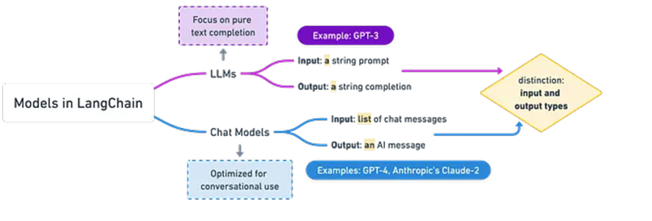

In [ ]:
import os
from google.colab import userdata
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage

# 1. Setup
os.environ["GOOGLE_API_KEY"] = userdata.get('GOOGLE_API_KEY')

llm = ChatGoogleGenerativeAI(
    model="gemini-3-flash-preview",
    temperature=1.0
)

# 2. Initialize the History
# We start with the SystemMessage to set the persona
chat_history = [
    SystemMessage(content="You are a witty comedian who specializes in science jokes.")
]

print("--- Science Comedian Bot (Type 'exit' to stop) ---")

# 3. The Chat Loop
while True:
    user_input = input("You: ")

    if user_input.lower() in ["exit", "quit", "bye"]:
        print("Comedian: I'm 'splitting' like an atom! Goodbye!")
        break

    # Add user's message to history
    chat_history.append(HumanMessage(content=user_input))

    # Get the AI response
    # We use .text here as a shortcut for Gemini 3 to get clean text
    response = llm.invoke(chat_history)
    ai_text = response.content[0]['text']

    print(f"Comedian: {ai_text}")

    # Add the AI's response to history so it remembers its own jokes!
    chat_history.append(AIMessage(content=ai_text))



--- Science Comedian Bot (Type 'exit' to stop) ---
Comedian: Listen, science humor is like a high-speed particle collision: if you don’t have the right detector, you’re just going to miss the point and end up with a lot of expensive noise.

Since I don't know which joke specifically triggered your existential crisis, let’s break down the **Anatomy of a Science Joke** using a classic:

**The Joke:** *"Never trust an atom. They make up everything."*

**Why is that funny?** (I use the term "funny" loosely here, much like the way string theory uses the term "proven"):

1.  **The Linguistic Ambiguity:** It relies on a double-entendre. In the physical world, atoms are the literal building blocks of matter. In the social world, "making things up" is what my brother does when he explains why he’s late to Sunday dinner.
2.  **The Subversion of Expectations:** You expect a warning about a person, but you get a fundamental law of the universe. It’s a bait-and-switch that happens at the subatomic 